## Why Yolo?
## The purpose of this competition is 'object detection'. Generally, object detection algorithms with deep learning take a long time to train model and require a lot of ## gpu resources. Most individual participants use one or two gpu (... or zero). Therefore, there is a need for algorithms that works quickly with less gpu resources.

### Note: BEFORE RUNNING THIS NOTEBOOK, CHANGE THE NOTEBOOK SETTINGS TO "GPU" BY DEFAULT ITS CPU

### Installing and Loading libraries. Following is a brief description of some important libraries used in this code

### 1.   pydicom is a pure python package for working with DICOM files
### 2.   tqdm is used to a Instantly make loops show a smart progress meter
### 3.   A library for image augmentation in machine learning experiments, particularly convolutional neural networks


In [1]:
#@title
!pip install --upgrade pip
!pip uninstall kaggle

     |████████████████████████████████| 1.5MB 7.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Would remove:
    /usr/local/bin/kaggle
    /usr/local/lib/python3.6/dist-packages/kaggle-1.5.6.dist-info/*
    /usr/local/lib/python3.6/dist-packages/kaggle/*
Proceed (y/n)? y
  Successfully uninstalled kaggle-1.5.6


In [2]:
!pip install -q pydicom 
!pip install -q tqdm 
!pip install -q imgaug
!pip install kaggle

     |████████████████████████████████| 35.4 MB 38 kB/s 
     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=74392f1b6d11e1b8087a8bbc8f8aa8718b840f8ff10da1190eb93cc3a559520a
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


In [3]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
##Set the environment variables

os.environ['KAGGLE_USERNAME']="krteja45" 
os.environ['KAGGLE_KEY']="21b35f69009541f23401c51d79125068"  

#A mapping object representing the string environment

### Now below you have to enter your kaggle username and kaggle key and join this competetion
### By joining competetion only you can download the data directly from kaggle

In [5]:
ROOT_DIR = os.path.abspath('./kaggle_data')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [6]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.65G/3.66G [01:10<00:00, 87.0MB/s]
100% 3.66G/3.66G [01:10<00:00, 55.5MB/s]


#### Since the files are in zip format we will now unzip the files

In [7]:
!unzip -q -o rsna-pneumonia-detection-challenge.zip -d rsna-pneumonia-detection-challenge

In [8]:
random_stat = 123
np.random.seed(random_stat)

## Clone and Build YOLOv3

In [9]:
!git clone https://github.com/pjreddie/darknet.git

# Build gpu version darknet
!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment.
!cd darknet && make -j 999 -s
!cp darknet/darknet darknet_gpu

Cloning into 'darknet'...
remote: Enumerating objects: 5907, done.
remote: Total 5907 (delta 0), reused 0 (delta 0), pack-reused 5907
Receiving objects: 100% (5907/5907), 6.32 MiB | 8.45 MiB/s, done.
Resolving deltas: 100% (3923/3923), done.
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:957:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~


#### Data Migration for YOLOv3

#### Make subdirectories

In [10]:
DATA_DIR = "/content/kaggle_data/rsna-pneumonia-detection-challenge"

In [11]:
train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [12]:
!ls -shtl

total 3.7G
4.0K drwxr-xr-x  2 root root 4.0K Jun 19 07:44 backup
4.0K drwxr-xr-x  2 root root 4.0K Jun 19 07:44 cfg
4.0K drwxr-xr-x  2 root root 4.0K Jun 19 07:44 images
4.0K drwxr-xr-x  2 root root 4.0K Jun 19 07:44 labels
4.0K drwxr-xr-x  2 root root 4.0K Jun 19 07:44 metadata
1.9M -rwxr-xr-x  1 root root 1.9M Jun 19 07:44 darknet_gpu
4.0K drwxr-xr-x 13 root root 4.0K Jun 19 07:44 darknet
4.0K drwxr-xr-x  4 root root 4.0K Jun 19 07:43 rsna-pneumonia-detection-challenge
3.7G -rw-r--r--  1 root root 3.7G Jun 19 07:42 rsna-pneumonia-detection-challenge.zip


#### Load stage_2_train_labels.csv

In [13]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


####Generate images and labels for training YOLOv3
####YOLOv3 needs .txt file for each image, which contains ground truth object in the image that looks like:
####     <object-class_1>   <x_1>   <y_1>   <width_1>   <height_1> 
####     <object-class_2>   <x_2>   <y_2>   <width_2>   <height_2>

####  1. < object-class>: Since RSNA task is binary classification basically, <object-class> is 0.
####  2. < x >, < y >: Those are float values of bbox center coordinate, divided by image width and height respectively.
####  3. < w >, < h >: Those are width and height of bbox, divided by image width and height respectively.

#### So it is different from the format of label data provided by kaggle. We should change it using the following function

In [14]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
       
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [15]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████| 30227/30227 [02:56<00:00, 171.45it/s]


In [16]:
!du -sh images labels

990M	images
24M	labels


#### Let us plot a sample train image and label

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



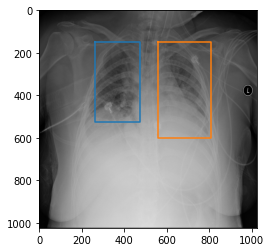

In [17]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

#### Generate train/val file path list (.txt)

#### We should give the list of image paths to YOLO. two seperate list textfiles for training images and validation images.

In [18]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [19]:
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)


The # of train set: 5410, The # of validation set: 602


#### Create test image and labels for YOLOv3

In [20]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

#### Plot a sample test Image

In [21]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)

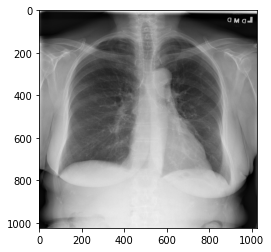

In [22]:
ex_patient_id = test_dcm_fps[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

#### Prepare Configuration Files for Using YOLOv3


####    rsna.data: This file points to RSNA data path

####    train: Path to training image list textfile
####    val: Path to validation image list textfile
####    names: RSNA class name list (can be seen below)
####    backup: A directory where trained weights(checkpoints) will be stored as training progresses.



In [23]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [24]:
!cat cfg/rsna.data

classes= 1
train  = /content/kaggle_data/metadata/tr_list.txt
valid  = /content/kaggle_data/metadata/val_list.txt
names  = /content/kaggle_data/cfg/rsna.names
backup = /content/kaggle_data/backup
    

#### cfg/rsna.names

In [25]:
# Label list of bounding box.
!echo "pneumonia" > cfg/rsna.names

## darknet53.conv.74 (Download Pre-trained Model)

####    For training, we would download the pre-trained model weights(darknet53.conv.74) using following wget command.

In [26]:
!wget -q https://pjreddie.com/media/files/darknet53.conv.74


### cfg/rsna_yolov3.cfg_train

####    Basically, we can use darknet/cfg/yolov3.cfg files. However it won't work for RSNA, we need to edit for RSNA.
####    We can just download a cfg file I edited for RSNA with following wget command.

In [27]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=18ptTK4Vbeokqpux8Onr0OmwUP9ipmcYO" -O cfg/rsna_yolov3.cfg_train

###Training YOLOv3

#### Command for training with Pre-trained CNN Weights (darknet53.conv.74)

In [28]:
!./darknet_gpu detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

### Command for training with Multi-gpu after 1000 iteration

####    Things to watch out:
####    1. Learning rate for training
####    2. Number of GPUs

In [29]:
!./darknet_gpu detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train backup/rsna_yolov3_1000.weights -gpus 0,1,2,3 | tee train_log.txt

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

### Plot of Training Loss

#### It's a loss graph up to about 2000 iteration

In [30]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1OhnlV3s7r6xsEme6DKkNYjcYjsl-C_Av" -O train_log.txt

(0.0, 4.05)

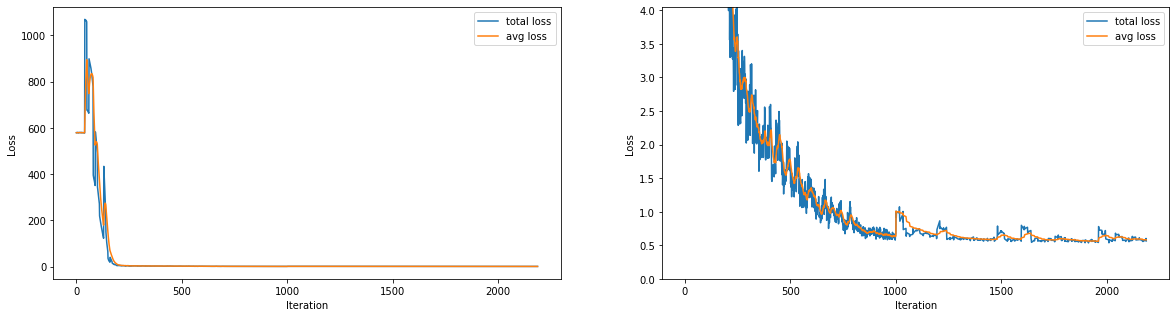

In [31]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 4.05])

#### Usage of trainined YOLOv3 for test images (command line)

##### Copy sample test image

In [32]:
ex_patient_id = annots[annots.Target == 1].patientId.values[2]
shutil.copy(ex_img_path, "test.jpg")
print(ex_patient_id)

00704310-78a8-4b38-8475-49f4573b2dbb


#### Load trained model (at 15300 iteration)

In [33]:
 !wget --load-cookies /tmp/cookies.txt -q "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd" -O backup/rsna_yolov3_15300.weights && rm -rf /tmp/cookies.txt

In [34]:
!ls -alsth backup

total 235M
235M -rw-r--r-- 1 root root 235M Jun 19 08:21 rsna_yolov3_15300.weights
4.0K drwxr-xr-x 2 root root 4.0K Jun 19 08:21 .
4.0K drwxr-xr-x 9 root root 4.0K Jun 19 08:21 ..


In [35]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=10Yk6ZMAKGz5LeBbikciALy82aK3lX-57" -O cfg/rsna_yolov3.cfg_test

In [36]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_15300.weights ../test.jpg -thresh 0.005

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

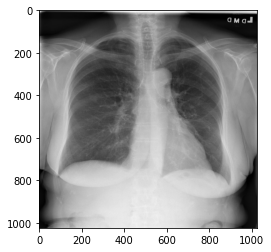

In [37]:
# ![](predictions.jpg)
plt.imshow(cv2.imread("./darknet/predictions.jpg"))

## Generate Submission Files with YOLOv3 Python Wrapper

In [38]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1-KTV7K9G1bl3SmnLnzmpkDyNt6tDmH7j" -O darknet.py

### Load darknet python wrapper module

In [39]:
from darknet import *

In [40]:
threshold = 0.2

In [41]:
submit_file_path = "submission.csv"
cfg_path = os.path.join(cfg_dir, "rsna_yolov3.cfg_test")
weight_path = os.path.join(backup_dir, "rsna_yolov3_15300.weights")

test_img_list_path = os.path.join(metadata_dir, "te_list.txt")

In [42]:
gpu_index = 0
net = load_net(cfg_path.encode(),
               weight_path.encode(), 
               gpu_index)
meta = load_meta(data_extention_file_path.encode())

In [43]:
submit_dict = {"patientId": [], "PredictionString": []}

with open(test_img_list_path, "r") as test_img_list_f:
    # tqdm run up to 1000(The # of test set)
    for line in tqdm(test_img_list_f):
        patient_id = line.strip().split('/')[-1].strip().split('.')[0]

        infer_result = detect(net, meta, line.strip().encode(), thresh=threshold)

        submit_line = ""
        for e in infer_result:
            confi = e[1]
            w = e[2][2]
            h = e[2][3]
            x = e[2][0]-w/2
            y = e[2][1]-h/2
            submit_line += "{} {} {} {} {} ".format(confi, x, y, w, h)

        submit_dict["patientId"].append(patient_id)
        submit_dict["PredictionString"].append(submit_line)

pd.DataFrame(submit_dict).to_csv(submit_file_path, index=False)

3000it [08:51,  5.64it/s]


In [44]:
!ls -alsht

total 3.9G
272K -rw-r--r--  1 root root 272K Jun 19 08:30 submission.csv
4.0K drwxr-xr-x 10 root root 4.0K Jun 19 08:30 .
4.0K drwxr-xr-x  2 root root 4.0K Jun 19 08:21 __pycache__
8.0K -rw-r--r--  1 root root 5.1K Jun 19 08:21 darknet.py
4.0K drwxr-xr-x 13 root root 4.0K Jun 19 08:21 darknet
4.0K drwxr-xr-x  2 root root 4.0K Jun 19 08:21 cfg
4.0K drwxr-xr-x  2 root root 4.0K Jun 19 08:21 backup
216K -rw-r--r--  1 root root 215K Jun 19 08:21 test.jpg
8.9M -rw-r--r--  1 root root 8.9M Jun 19 08:21 train_log.txt
628K drwxr-xr-x  2 root root 624K Jun 19 07:49 images
4.0K drwxr-xr-x  2 root root 4.0K Jun 19 07:47 metadata
448K drwxr-xr-x  2 root root 444K Jun 19 07:47 labels
1.9M -rwxr-xr-x  1 root root 1.9M Jun 19 07:44 darknet_gpu
4.0K drwxr-xr-x  4 root root 4.0K Jun 19 07:43 rsna-pneumonia-detection-challenge
3.7G -rw-r--r--  1 root root 3.7G Jun 19 07:42 rsna-pneumonia-detection-challenge.zip
4.0K drwxr-xr-x  1 root root 4.0K Jun 19 07:40 ..
155M -rw-r--r--  1 root root 155M Mar 25  2